In [1]:
import mechanize
from bs4 import BeautifulSoup
import http.cookiejar as cookielib
import pandas
cj = cookielib.CookieJar()
br = mechanize.Browser()
br.set_cookiejar(cj)
br.open("https://op.responsive.net/lt/<account>/entry.html")
br.select_form(nr=0)
br.form['id'] = '<group_username>'
br.form['password'] = '<group_pass>'
br.submit()

url_list = ["CASH","JOBIN","JOBQ","S1Q","S2Q","S3Q","S1UTIL","S2UTIL","S3UTIL"]
url_list_4col = ["JOBT","JOBREV","JOBOUT"]

LF_DATA = {}
#get INVENTORY first
inv_url = "http://op.responsive.net/Littlefield/Plot?data=INV&x=all"
soup = BeautifulSoup(br.open(inv_url), "lxml")



In [2]:
data = soup.find_all("script")[6].string
data = data.split("\n")[4].split("'")[3].split()


In [3]:
counter = 1
for i in data:
    if counter % 2 == 1:
        counter += 1
        day = float(i)
        LF_DATA[day] = []
    elif counter % 2 == 0:
        row_data = [float(i)]
        LF_DATA[day].extend(row_data)
        counter += 1

In [4]:
#iterate through and scrape all two-column tables
for url in url_list:
    lf_url = "http://op.responsive.net/Littlefield/Plot?data=%s&x=all" % url
    soup = BeautifulSoup(br.open(lf_url), "lxml")
    data = soup.find_all("script")[6].string
    data = data.split("\n")[4].split("'")[3].split()
    counter = 1
    for i in data:
        if counter % 2 == 0:
            day = counter/2
            LF_DATA[day].append(float(i))
            counter += 1
        else:
            counter +=1

In [5]:
#iterate through and scrape all four-column tables
for url in url_list_4col:
    lf_url = "http://op.responsive.net/Littlefield/Plot?data=%s&x=all" % url
    soup = BeautifulSoup(br.open(lf_url), "lxml")
    data = soup.find_all("script")[6].string
    data0 = data.split("\n")[4].split("'")[5].split()
    data1 = data.split("\n")[5].split("'")[5].split()
    data2 = data.split("\n")[6].split("'")[5].split()

    counter = 1
    for i in data0:
        if counter % 2 == 0:
            day = counter/2
            LF_DATA[day].append(float(i))
            counter += 1
        else:
            counter +=1
    counter = 1
    for i in data1:
        if counter % 2 == 0:
            day = counter/2
            LF_DATA[day].append(float(i))
            counter += 1
        else:
            counter +=1
    counter = 1
    for i in data2:
        if counter % 2 == 0:
            day = counter/2
            LF_DATA[day].append(float(i))
            counter += 1
        else:
            counter +=1

In [6]:
# Add dummy data to fill out fractional day rows
dummy_data = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for key, value in LF_DATA.items():
    if len(value) < 19:
        value.extend(dummy_data)
headers = ["Inventory","Cash","AcceptedJob","JobQ","Station1Q","Station2Q","Station3Q","Station1Util","Station2Util","Station3Util","LeadC1","LeadC2","LeadC3","RevC1","RevC2","RevC3","CompC1","CompC2","CompC3"]
df = pandas.DataFrame.from_dict(LF_DATA, orient="index")
df.columns = headers
df.sort_index(inplace=True)
df["Backlog"] = df["AcceptedJob"].cumsum() - df["CompC1"].cumsum() - df["CompC2"].cumsum() - df["CompC3"].cumsum()

In [7]:
writer = pandas.ExcelWriter('./latest_data.xlsx')
df.to_excel(writer,'data')
writer.close()

In [8]:
df

,Inventory,Cash,AcceptedJob,JobQ,Station1Q,Station2Q,Station3Q,Station1Util,Station2Util,Station3Util,LeadC1,LeadC2,LeadC3,RevC1,RevC2,RevC3,CompC1,CompC2,CompC3,Backlog
1.000,147.0,4.500,13.0,0.0,1.072,0.637,0.456,0.777,0.614,0.674,0.527,0.0,0.000,750.0,0.0,0.000,6.0,0.0,0.0,7.0
2.000,132.0,12.003,15.0,0.0,2.045,1.515,1.632,0.987,0.801,0.712,0.737,0.0,0.000,750.0,0.0,0.000,10.0,0.0,0.0,12.0
3.000,124.0,21.007,8.0,0.0,1.006,2.456,2.358,0.865,0.947,0.684,0.866,0.0,0.000,750.0,0.0,0.000,12.0,0.0,0.0,8.0
4.000,105.0,30.014,19.0,0.0,4.412,2.465,2.163,0.916,0.926,0.819,0.865,0.0,0.000,750.0,0.0,0.000,12.0,0.0,0.0,15.0
5.000,91.0,39.023,14.0,0.0,4.854,4.240,1.135,1.000,1.000,0.726,1.075,0.0,0.000,750.0,0.0,0.000,12.0,0.0,0.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266.000,24.0,588.707,15.0,0.0,4.663,0.129,0.000,1.000,0.556,0.217,0.000,0.0,0.592,0.0,0.0,992.703,0.0,0.0,15.0,10.0
267.000,12.0,598.234,12.0,0.0,4.552,0.037,0.006,1.000,0.540,0.337,0.000,0.0,0.712,0.0,0.0,720.978,0.0,0.0,13.0,9.0
267.743,0.0,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,9.0
267.787,120.0,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,9.0


In [9]:
import matplotlib.pyplot as plt

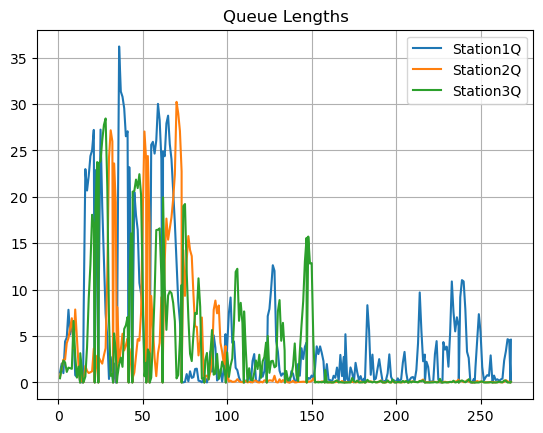

In [10]:
fig, ax = plt.subplots()
df.plot(y=["Station1Q","Station2Q","Station3Q"], title="Queue Lengths", ax = ax)
plt.grid()
plt.show()

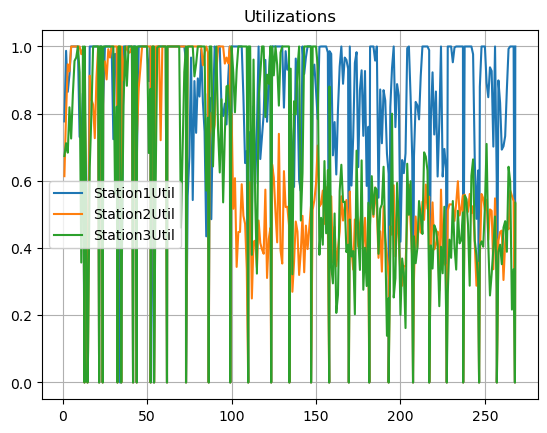

In [11]:
fig, ax = plt.subplots()
df.plot(y=["Station1Util","Station2Util","Station3Util"], title="Utilizations", ax = ax)
plt.grid()
plt.show()

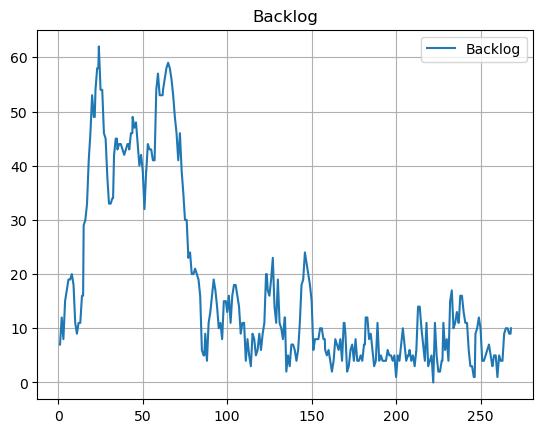

In [12]:
fig, ax = plt.subplots()
df.plot(y=["Backlog"], title="Backlog", ax = ax)
plt.grid()
plt.show()

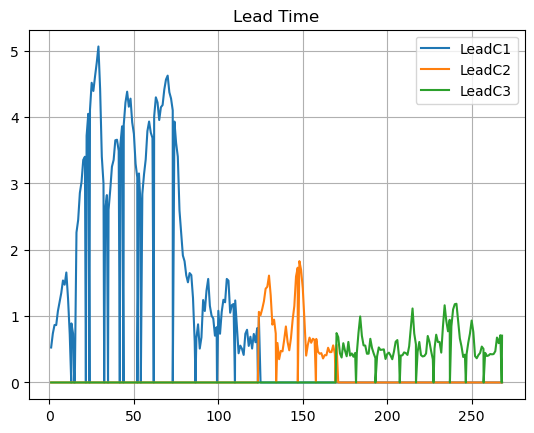

In [13]:
fig, ax = plt.subplots()
df.plot(y=["LeadC1","LeadC2","LeadC3"], title="Lead Time", ax = ax)
plt.grid()
plt.show()